In [1]:
# %pip install git+https://github.com/Altanali/amazon-braket-sdk-python.git@add_ahs_add_meas_noise
# %pip install git+https://github.com/amazon-braket/amazon-braket-default-simulator-python.git@mao/ahs_tn_julia_noise

Below cell will take ~5 min to complete

In [2]:
# import subprocess

# # Install Julia
# subprocess.run(['wget', 'https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.4-linux-x86_64.tar.gz'])
# subprocess.run(['tar', '-xvzf', 'julia-1.10.4-linux-x86_64.tar.gz'])
# subprocess.run(['sudo', 'cp', '-r', 'julia-1.10.4', '/opt/'])
# subprocess.run(['sudo', 'ln', '-s', '/opt/julia-1.10.4/bin/julia', '/usr/local/bin/julia'])

# # Install Julia packages
# subprocess.run(['julia', '-e', """using Pkg; Pkg.instantiate(); Pkg.add(url = "https://github.com/amazon-braket/BraketAHS.jl.git", rev = "tdvp"); Pkg.add("JSON3"); Pkg.precompile()"""])

In [3]:
pip freeze | grep amazon

amazon-braket-algorithm-library==1.4.13
amazon-braket-default-simulator @ git+https://github.com/amazon-braket/amazon-braket-default-simulator-python.git@c333ad708dd18142001fdc7675f538c7e4cd94c4
amazon-braket-pennylane-plugin==1.28.0
amazon-braket-schemas==1.22.0
amazon-braket-sdk @ git+https://github.com/Altanali/amazon-braket-sdk-python.git@8bb7216014b7cb7b60abdda11508c09b4d4c7db6
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Interestingly, we have load LocalSimulator('braket_ahs_tn_noisy') here
# so that the following cell can be run successfully..
# need to debug this behavior

from braket.devices import LocalSimulator
simulator = LocalSimulator('braket_ahs_tn_noisy')
# simulator = LocalSimulator('braket_ahs_tn')
# simulator = LocalSimulator('braket_ahs_noisy')
# simulator = LocalSimulator('braket_ahs')

i am at braket_ahs_tn_noisy


# This example, which includes 24 atoms, is better run on a large instance with ~100 cores

In [5]:
import os

print(os.cpu_count())

96


# Noisy quantum evolution with Rydberg atoms


Noise is ubiquitous in quantum computers which affects the accuracy of the calculations they perform. Various sources could contribute to the noise in a quantum computer, including cosmic rays, disturbances caused by an approaching train, or even the ambient light of the room where the quantum computer sits. These sources of error could affect qubit lifetimes, gate fidelities, and the reliability of preparation and measurement. In previous notebooks, we have introduced [the noise models on Amazon Braket](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Amazon_Braket.ipynb) and [those on Rigetti](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb), which focus on the noise models for gate-based devices. In this notebook, we will dive deep into several sources of noise for Rydberg devices, which have different underlying physics, and understand how they affect the analog Hamiltonian simulation (AHS) program running on these devices. In particular, we will use the coherent evolution of the Bell state of a pair Rydberg atoms under the AHS Hamiltonian to illustrate the effects of different noise sources."

## Creating and evolving a Bell state with Rydberg atoms

[Bell states](https://en.wikipedia.org/wiki/Bell_state) are a set of maximally entagled states of two qubits. Here, we consider creating and evolving a Bell state with Rydberg atoms in the presence of noise. We will see how noise affects the quality of the prepared Bell state and its quantum evolution. 

For a pair of atoms, their Rydberg Hamiltonian can be written as a $4\times4$ matrix in the basis of $\left\{|gg\rangle, |gr\rangle, |rg\rangle, |rr\rangle\right\}$
\begin{align}
H = 
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & -\Delta & 0 & \frac{\Omega}{2}\\
\frac{\Omega}{2} & 0 & -\Delta & \frac{\Omega}{2}\\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & V-2\Delta
\end{bmatrix}.
\end{align}
Here $\Omega$ and $\Delta$ are the amplitude and detuning of a time-varying global driving field, and $V\equiv C_6/R^6$ is the interaction strength between the two atoms which depends on their distance $R$ and a constant $C_6\equiv 5.42\times10^{-24} \text{ rad m}^6/\text{s}$. To create a Bell state, we consider putting the two atoms within the Rydberg blockade radius. As discussed in [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb), if both atoms are subject to zero detuning ($\Delta=0$), it is very unlikely to excite both atoms to the Rydberg states simultaneously and effectively there are only three states in the Hilbert space, namely $|gg\rangle$, $|gr\rangle$ and $|rg\rangle$. Suppose the two atoms are initilized in the ground state and the amplitude of the driving field, which has duration $T$, satisfies (we will refer to the following quantity as amplitude area below)
\begin{align}
\int_{0}^T\Omega(t)dt = \frac{\pi}{\sqrt{2}},
\end{align}
then one can show that the final state of the two atoms is a Bell state, i.e.,
\begin{align}
|\phi_1\rangle = \exp\left\{-i
\begin{bmatrix}
0 & \frac{\pi}{2\sqrt{2}} & \frac{\pi}{2\sqrt{2}}\\
\frac{\pi}{2\sqrt{2}} & 0 & 0 \\
\frac{\pi}{2\sqrt{2}} & 0 & 0
\end{bmatrix}
\right\} 
\begin{bmatrix}
|gg\rangle \\
|gr\rangle \\
|rg\rangle
\end{bmatrix}
=-\frac{i}{\sqrt{2}}(|gr\rangle + |rg\rangle).
\end{align}


After the Bell state is created, we consider its evolution subject to a global driving field with nonzero amplitude and detuning. In particular, the detuing is set to a constant value that is *exactly* equal to the interaction between the two atoms, i.e., $V=\Delta$. In this case, because $-\Delta=-V\ll 0$, the states $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$ are at the energy levels much smaller than that of $|gg\rangle$, and hence the evolution is approximately governed by the $3\times3$ Hamiltonian
\begin{align}
H = 
\begin{bmatrix}
 -\Delta & 0 & \frac{\Omega}{2}\\
 0 & -\Delta & \frac{\Omega}{2}\\
 \frac{\Omega}{2} & \frac{\Omega}{2} & -\Delta
\end{bmatrix},
\end{align}
in the basis of $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$. With the initial state being the Bell state $|\phi_1\rangle$, we can solve the time-dependent wave function as (up to a global phase)
\begin{align}
|\psi(t)\rangle = \cos\frac{\Omega t}{\sqrt{2}}|\phi_1\rangle - \sin\frac{\Omega t}{\sqrt{2}}|rr\rangle.
\end{align}
It is clear that $|\psi(t=0)\rangle=|\phi_1\rangle$, and its evolution can be viewed as an oscillation between $|\phi_1\rangle$ itself and $|rr\rangle$. This demonstrates that, with strong global detuning applied to two atoms within the blockade radius, we can excite both atoms to the Rydberg states which is otherwise forbidden by the strong Rydberg blockade interaction.

Below we first exhibit a noiseless AHS program that realizes the creation and evolution of Bell states, followed by showing how to add various noise to the program and their impact to the result of the program. Finally we submit the noiseless AHS program to Aquila and compare the result to the noise simulation result. 

## Noiseless AHS program for creating and evolving a Bell state

In [6]:
from pprint import pprint as pp
from braket.aws import AwsDevice 

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm

In [7]:
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from ahs_utils import show_global_drive, show_register, show_drive_and_local_detuning
from braket.ahs.driving_field import DrivingField
from braket.timings.time_series import TimeSeries

amplitude_max = float(capabilities.rydberg.rydbergGlobal.rabiFrequencyRange[-1])
detuning_slew_rate = float(capabilities.rydberg.rydbergGlobal.detuningSlewRateMax)
amplitude_slew_rate = float(capabilities.rydberg.rydbergGlobal.rabiFrequencySlewRateMax)
time_separation_min = float(capabilities.rydberg.rydbergGlobal.timeDeltaMin)
height = float(capabilities.lattice.area.height)
width = float(capabilities.lattice.area.width)
C6 = float(capabilities.rydberg.c6Coefficient)


def create_evolve_bell_states(
    atom_separation: float = 6.7e-6, # The separation of the two atoms used throughout the notebook
    amplitude_area: float = 0.0,
    if_show_global_drive: bool = False,
    if_parallel: bool = False,
    patch_separation: float = 24e-6,
) -> AnalogHamiltonianSimulation:
    """
    Return an AHS program to create and evolve a Bell state with Rydberg atoms

    Args:
        atom_separation (float): The separation of the two atoms
        amplitude_area (float): The area of the amplitude for the evolution
        if_show_global_drive (bool): If true, a figure for global drive will be shown
        if_parallel (bool): If true, multiple patches of the two atoms will be created,
            which is typically used when running simulation on the quantum hardware
        patch_separation (float): The vertical and horizontal separations of the patches

    Returns:
        (AnalogHamiltonianSimulation): The AHS program for creating and evolving a Bell state
    """    
    
    detuning_max = C6/(atom_separation**6)
    t_ramp_detuning = detuning_max / detuning_slew_rate
    t_ramp_detuning = max(t_ramp_detuning, time_separation_min)
    
    # Define register
    coords = [(0, 0), (0, atom_separation)]
    if if_parallel:
        # Extend along y direction
        n_height = int(height // (atom_separation + patch_separation))
        if n_height * (atom_separation + patch_separation) + atom_separation < height:
            n_height += 1
            
        for i in range(n_height-1):
            coords.append((0, patch_separation * (i+1)))
            coords.append((0, atom_separation + patch_separation * (i+1)))
            
        # Extend along x direction
        n_width = int(width // patch_separation)
        if n_width * patch_separation < width:
            n_width += 1
        
        for i in range(n_width-1):
            for j in range(n_height):
                coords.append((patch_separation * (i+1), patch_separation * j))
                coords.append((patch_separation * (i+1), atom_separation + patch_separation * j))
    
    register = AtomArrangement()
    for coord in coords:
        register.add(coord)

    # Prepare the Bell state
    amplitude = TimeSeries.trapezoidal_signal(np.pi/np.sqrt(2), amplitude_max, amplitude_slew_rate, time_separation_min=time_separation_min)
    detuning = TimeSeries.constant_like(amplitude, 0.0)
    phase = TimeSeries.constant_like(amplitude, 0.0)
    
    
    # Evolve
    if amplitude_area > 0:
        
        # Ramp up the detuning
        t_prep = amplitude.times()[-1]
        amplitude.put(t_prep + t_ramp_detuning, 0.0)
        detuning.put(t_prep + t_ramp_detuning, detuning_max)
        phase.put(t_prep + t_ramp_detuning, 0.0)

        amplitude_evolve = TimeSeries.trapezoidal_signal(amplitude_area, amplitude_max, amplitude_slew_rate, time_separation_min=time_separation_min)
        amplitude = amplitude.stitch(amplitude_evolve)
        detuning = detuning.stitch(TimeSeries.constant_like(amplitude_evolve, detuning_max))
        phase = phase.stitch(TimeSeries.constant_like(amplitude_evolve, 0.0))
    
    
    drive = DrivingField(amplitude=amplitude, phase=phase, detuning=detuning)
    
    if if_show_global_drive:
        show_global_drive(drive)
                
    program = AnalogHamiltonianSimulation(
        register = register,
        hamiltonian = drive
    )
    
    return program

def aggregate_counters(counters: dict[str, int]) -> dict[str, int]:
    
    states = ['gg', 'gr', 'rg', 'rr']
    counters2 = {state: 0 for state in states}    
    shots = 0
    for key, val in counters.items():
        for i in range(int(len(key)/2)):
            state = key[2*i:2*i+2]
            if state in counters2.keys():
                counters2[state] += val 
                shots += val
    
    for key, val in counters2.items():
        counters2[key] = val/shots
                
    return counters2

Below we show an example AHS program. The first part of the program creates a Bell state with zero detuning, and then the detuning is ramped up to a constant value followed by a trapezoidal waveform for the amplitude which is similar to that used to create the Bell state. The evolution of the Bell state can be realized by varying the area of the second trapezoidal waveform for the amplitude. We note that because of the finite ramping time of the amplitude, the evolution of the Bell state will have slight discrepancy compared to the ideal Rabi oscillation between $|\phi_1\rangle$ and $|rr\rangle$, as described above. But as the ramping time is only of the order of $10^{-8}$ seconds, the discprepancy is very small as we will see below.

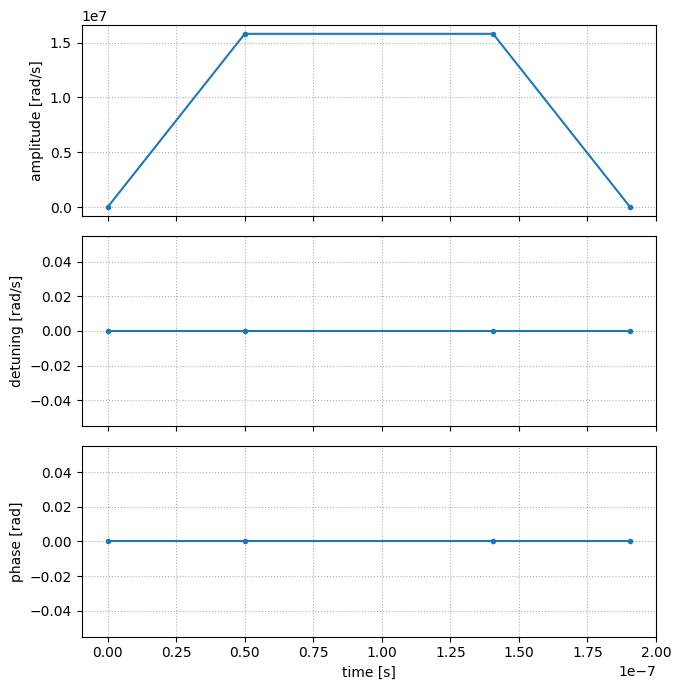

In [8]:
import numpy as np

program_1 = create_evolve_bell_states(amplitude_area = 0, if_show_global_drive=True, if_parallel=True) ;

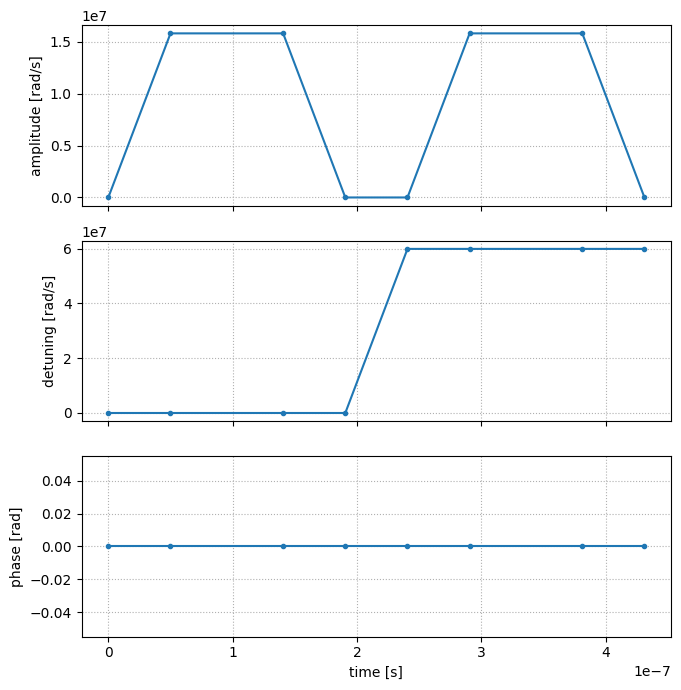

In [9]:
program_2 = create_evolve_bell_states(amplitude_area = np.pi/np.sqrt(2), if_show_global_drive=True, if_parallel=True) ;

# We are using a large atom array, which requires Julia

In [10]:
sum(program_2.to_ir().setup.ahs_register.filling)

24

In [11]:
sum(program_1.to_ir().setup.ahs_register.filling)

24

# Device emulation: validation

In [12]:
task_1_emu = qpu.validate(program_1)

Exception: 1 validation error for DeviceDrivingFieldValidator
__root__
  time point 2 (1.405975613341255E-7) of amplitude time_series is defined with too many digits; it must be an integer multiple of 1E-9 (type=value_error) (Aquila)

In [13]:
task_1_emu = qpu.validate(program_1.discretize(qpu))

# Device emulation: emulation

In [16]:
shots = os.cpu_count()

In [14]:
task_1_emu = qpu.emulate(program_1.discretize(qpu), shots=shots) # default parameters: steps=100, solver="tebd", max_bond_dim=4

[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	i

In [15]:
aggregate_counters(task_1_emu.result().get_counts())

{'gg': 0.10785953177257525,
 'gr': 0.4205685618729097,
 'rg': 0.4230769230769231,
 'rr': 0.048494983277591976}

In [17]:
task_2_emu = qpu.emulate(program_2.discretize(qpu), shots=shots)

[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-path: ahs_program.json
[ Info: 	interaction-radius: 9.2e-6
[ Info: 	C6: 5.42e-24
[ Info: 	n-tau-steps: 60
[ Info: 	solver: tebd
[ Info: 	shots: 1000
[ Info: JSON file to read: ahs_program.json
[ Info: Parsed input arguments
[ Info: Parsed input arguments
[ Info: 	cutoff: 1.0e-7
[ Info: 	max-bond-dim: 4
[ Info: 	program-pa

In [18]:
aggregate_counters(task_2_emu.result().get_counts())

{'gg': 0.028795811518324606,
 'gr': 0.12041884816753927,
 'rg': 0.12827225130890052,
 'rr': 0.7225130890052356}

# Show the noisy program

In [19]:
program_1.to_ir().setup.ahs_register.sites # Setup for the noiseless program

[[Decimal('0'), Decimal('0')],
 [Decimal('0'), Decimal('0.0000067')],
 [Decimal('0'), Decimal('0.000024')],
 [Decimal('0'), Decimal('0.0000307')],
 [Decimal('0'), Decimal('0.000048')],
 [Decimal('0'), Decimal('0.0000547')],
 [Decimal('0.000024'), Decimal('0.0')],
 [Decimal('0.000024'), Decimal('0.0000067')],
 [Decimal('0.000024'), Decimal('0.000024')],
 [Decimal('0.000024'), Decimal('0.0000307')],
 [Decimal('0.000024'), Decimal('0.000048')],
 [Decimal('0.000024'), Decimal('0.0000547')],
 [Decimal('0.000048'), Decimal('0.0')],
 [Decimal('0.000048'), Decimal('0.0000067')],
 [Decimal('0.000048'), Decimal('0.000024')],
 [Decimal('0.000048'), Decimal('0.0000307')],
 [Decimal('0.000048'), Decimal('0.000048')],
 [Decimal('0.000048'), Decimal('0.0000547')],
 [Decimal('0.000072'), Decimal('0.0')],
 [Decimal('0.000072'), Decimal('0.0000067')],
 [Decimal('0.000072'), Decimal('0.000024')],
 [Decimal('0.000072'), Decimal('0.0000307')],
 [Decimal('0.000072'), Decimal('0.000048')],
 [Decimal('0.00007

In [20]:
program_1_noisy = qpu.run_passes(program_1.discretize(qpu))
program_1_noisy.to_ir().setup.ahs_register.sites # Setup for the noisy program

[[Decimal('-2.039928503411785E-9'), Decimal('1.1098518266485105E-7')],
 [Decimal('-8.44235009526127E-8'), Decimal('0.000006695006892405588')],
 [Decimal('-1.0251395119221338E-7'), Decimal('0.000024015298796714418')],
 [Decimal('1.9700998845956649E-7'), Decimal('0.00003075073365655173')],
 [Decimal('-4.8025637842648244E-8'), Decimal('0.00004792510251764499')],
 [Decimal('-2.0046422455400807E-7'), Decimal('0.00005488719280430941')],
 [Decimal('0.000023725509760772694'), Decimal('-1.938757643428025E-9')],
 [Decimal('0.000024072282417870678'), Decimal('0.000006673498665214765')],
 [Decimal('0.000023951744631106018'), Decimal('0.000023965904892551503')],
 [Decimal('0.00002413872947705266'), Decimal('0.000030656861644946764')],
 [Decimal('0.000024055248941203595'), Decimal('0.000048012760877874256')],
 [Decimal('0.000024021445978439883'), Decimal('0.00005457999251203962')],
 [Decimal('0.00004800523469905343'), Decimal('4.078841735032823E-8')],
 [Decimal('0.00004819605298532316'), Decimal('0.

In [21]:
program_1.to_ir().hamiltonian.drivingFields[0].amplitude

PhysicalField(time_series=TimeSeries(values=[Decimal('0'), Decimal('15800000.0'), Decimal('15800000.0'), Decimal('0')], times=[Decimal('0'), Decimal('5E-8'), Decimal('1.405975613341255E-7'), Decimal('1.905975613341255E-7')]), pattern='uniform')

In [22]:
program_1_noisy.to_ir().hamiltonian.drivingFields[0].amplitude

PhysicalField(time_series=TimeSeries(values=[Decimal('0'), Decimal('471764.9820568068'), Decimal('949126.9528907201'), Decimal('1406750.955055695'), Decimal('2014315.0199344468'), Decimal('2496475.827282264'), Decimal('2992511.871445426'), Decimal('3532255.884617412'), Decimal('3927070.9109841604'), Decimal('4549472.6804240905'), Decimal('5206136.103589822'), Decimal('5770173.702803306'), Decimal('6399885.824559882'), Decimal('6703213.39900291'), Decimal('7627831.27778547'), Decimal('8086992.274667271'), Decimal('8570396.759664921'), Decimal('9543762.081845257'), Decimal('10472955.45224715'), Decimal('10992759.733572107'), Decimal('11452256.195789117'), Decimal('12332586.777830377'), Decimal('13155944.979995174'), Decimal('13529279.230597083'), Decimal('14017941.28082358'), Decimal('15637256.365839096'), Decimal('15798587.605168104'), Decimal('15434378.75534326'), Decimal('15796553.930301616'), Decimal('15317857.287839746'), Decimal('16288226.239026094'), Decimal('15982581.524777725'),